# Data Mining and Visualization-Part 3
In this second part of the project, I will create a classification model that will be used by the marketing managers of the insurance company to decide which new potential customers to contact.

In [1]:
#conda install -c conda-forge imbalanced-learn

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
 

from sklearn.naive_bayes import GaussianNB 
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier,Pool
from sklearn.ensemble import BaggingClassifier

from scipy import stats 
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score### data evaluation 

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler


we corrected the problem from the previous task, now we did the pre-process on the whole data and then splitted and saved into 2 csv files (before the prediction on the test we will concat them together)

In [10]:
train = pd.read_csv("./marketing_campaigns_train_final_part1.csv")
valid = pd.read_csv("./marketing_campaigns_validation_final_part1.csv")
train.columns

Index(['id ', 'status', 'education', 'profession', 'device', 'loan',
       'mortgage', 'credit', 'positive', 'subscribed', 'p_participant',
       'l_season', 'debts', 'age_z_norm', 'account_balance_z_norm',
       'n_contact_z_norm', 'l_call_duration_z_norm', 'n_p_contact_z_norm',
       'l_day_z_norm', 'l_season_z_norm', 'debts_z_norm', 'l_day_bin',
       'account_balance_bin', 'age_bin', 'n_contact_bin',
       'l_call_duration_bin'],
      dtype='object')

#### train_test_split on the valid data 

we will run models on the valid data we created so we need to split the data to train and test as we did in the previous task

In [11]:
X_valid = valid.drop(['subscribed'], axis=1)
y_valid = valid['subscribed']

we will keep all the different types of the data in a dictionary data_option_dict, the keys are the names of the data and the values are the data

In [12]:
data_option_dict = {}
clf_list=[]

when we find the best type of data for each midel and its hyper parameters we will run a model evaluation (we wull run the wanted model with the wanted data on number of foldes) and we will store the accuracy of each fold in a dictionary model_dict 

* __data option 1: data_cat_no_debts__ <br>
all the data is in categories (discrete) <br>
the columns are: <br>
'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant', 'subscribed', 'l_season', 'l_call_duration', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin'

In [13]:
data_cat_no_debts = train[[ 'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant',
        'subscribed', 'l_season', 'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

valid_cat_no_debts = valid[[ 'status', 'profession', 'device', 'loan', 'mortgage', 'credit', 'positive', 'p_participant',
        'subscribed', 'l_season', 'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

In [14]:
data_option_dict['data_cat_no_debts'] = data_cat_no_debts

* __data option 2: data_norm_and_not_with_debts__ <br>
data with also normalized and not nomalized columns. <br>
the columns are: <br>
'status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 'l_call_duration_z_norm', 
'account_balance_z_norm', 'n_contact_z_norm', 'l_day_z_norm'

In [15]:
data_norm_and_not_with_debts = train[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                                   'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm', 'age_z_norm', 'l_day_z_norm']].copy()

valid_norm_and_not_with_debts = valid[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                                   'l_call_duration_z_norm', 'account_balance_z_norm', 'n_contact_z_norm', 'age_z_norm', 'l_day_z_norm']].copy()

In [16]:
data_option_dict['data_norm_and_not_with_debts'] = data_norm_and_not_with_debts

* __data option 3: data_cat_with_debts__ <br>
the data is the data from option 1, but now instead of using the columns 'loan', 'mortgage', 'credit' and 'positive', we will only use the column 'debts'. <br>
the columns are: <br>
'status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 'l_call_duration', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin'

In [17]:
data_cat_with_debts = train[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                              'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()
valid_cat_with_debts = valid[['status', 'profession', 'device', 'debts', 'p_participant', 'subscribed', 'l_season', 
                              'l_call_duration_bin', 'l_day_bin', 'account_balance_bin', 'age_bin', 'n_contact_bin']].copy()

In [18]:
data_option_dict['data_cat_with_debts'] = data_cat_with_debts

* __data option 4: data_cat_no_debts_dummies__ <br>
the data is the data from option 1, but now we will also create dummies for every one of the columns.

In [19]:
# function to divide the data into dummies
def divide_to_dummies(data):
    dummies_col = [col for col in data if len(data[col].unique()) > 2 and len(train[col].unique()) < 13]
    data_dummies = pd.get_dummies(data = data, columns = dummies_col )
    return data_dummies

In [20]:
data_cat_no_debts_dummies = divide_to_dummies(data_cat_no_debts.copy())
valid_cat_no_debts_dummies = divide_to_dummies(valid_cat_no_debts.copy())

In [21]:
data_option_dict['data_cat_no_debts_dummies'] = data_cat_no_debts_dummies

* __data option 5: data_cat_with_debts_dummies__ <br>
the data is the data from option 3, but now we will also create dummies for every one of the columns.

In [22]:
data_cat_with_debts_dummies = divide_to_dummies(data_cat_with_debts.copy())
valid_cat_with_debts_dummies = divide_to_dummies(valid_cat_with_debts.copy())

In [23]:
data_option_dict['data_cat_with_debts_dummies'] = data_cat_with_debts_dummies

### Calculating Loss according the cost matrix 

Cost matrix: 

|  | predicted False | predicted True |
|:--- | :---: | :---: |
| <b>actual False</b> | 0 | C(T/F) = 1|
| <b>actual True<b> | C(F/T) = 15 | 0|

### $ Loss = fp\cdot cfp + fn\cdot cfn $ <br>
- $cfp$: false positive cost =1
- $cfn$: false negative cost=15


#### The misclasification cost:

In [24]:
cfp = 1
cfn = 15

In [25]:
def loss_calc(cm):
    fp = cm[0][1]
    fn = cm[1][0]
    return fp + fn*15

In [26]:
def cost_calc(y_test,y_pred):
    cm=metrics.confusion_matrix(y_test, y_pred)
    return loss_calc(cm)

In [27]:
cost=metrics.make_scorer(cost_calc, greater_is_better=False)

### data evaluation 

we will use this function in order to evaluate a spesific given classifier with different types of data. <br> 
* input: data_option_dict - a dictionary in which are all the different types of the data, the keys are the names of the data and the   values are the data itself. <br>
  clf - the name classifier for which we want to find the best type of data 
* output: cm_dict - dictionary of confussion matrix for each of the data types, <br>
   loss_dict - dictionary of loss values for each of the data types

for each classifier we will compare between different types of data which are stored in a dictionary. we will run the data_cv function with the default classifier (without finding the best parameters),
after we find the loss values of this classifier with everyone of the data types, we will use a ttest to find the best type of data for each of the classifiers


In [28]:
def data_cv(data_dict, clf):
    cm_dict, loss_dict = {}, {}
    #auc_dict={}
    kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    for data in data_dict.keys():
        X = data_dict[data].drop(['subscribed'], axis = 1)
        y = data_dict[data]['subscribed']
        X = X.to_numpy()
        #print("\n","------",data,"------")
        for train_index, test_index in kf.split(X,y):
            # split to train and test
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
            # train the model and make a prediction
            clf.fit(X_train, y_train)
            y_pred_best = clf.predict(X_test)
            
            cm=metrics.confusion_matrix(y_test, y_pred_best)
            loss=loss_calc(cm)
            
            # save the results
            cm_list = cm_dict.get(data,[])
            cm_list.append(cm)
            cm_dict[data] = cm_list

            loss_list = loss_dict.get(data,[])
            loss_list.append(loss)
            loss_dict[data] = loss_list

           # print("Loss: ", loss)
            #print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

    return  cm_dict, loss_dict
    
    
    

#### function to print classifier

In [29]:
def print_clf(clf, X_test, y_test,y_pred=1):
    if y_pred==1:
        y_pred = clf.predict(X_test)
    cm=metrics.confusion_matrix(y_test, y_pred)
    #acc = (cm[0][0]+cm[1][1])/sum(sum(cm))
    loss=loss_calc(cm)
    print('confusion matrix:')
    display(pd.DataFrame(cm))
    #print('accuracy: ',acc)
    print('Cost:',loss)

### Determine the treshold value
we will use this function in order to determine the treshold value of a spesific given classifier . <br> 
* input:clf - the name classifier for which we want to find the best type of data <br>
    X_train, X_test, y_train, y_test- the best data for this model after splitting
* output: min_threshold-the treshold value that minimize the cost  <br>

In [30]:
def min_threshold_value(clf,X_train, X_test, y_train, y_test):
    
    y_prob_test = clf.predict_proba(X_test)
    y_prob_train = clf.predict_proba(X_train)
    loss_list,loss_list_train = [],[]
    for t in np.arange(0, 1, 0.05):
        y_pred_test = [0 if p[1]<t else 1 for p in y_prob_test]
        cm_test = metrics.confusion_matrix(y_test,y_pred_test)
        loss_test = loss_calc(cm_test)
        loss_list.append(loss_test)

        y_pred_train = [0 if p[1]<t else 1 for p in y_prob_train]
        cm_train = metrics.confusion_matrix(y_train,y_pred_train)
        loss_train = loss_calc(cm_train)
        loss_list_train.append(loss_train)

    plt.xlabel("Threshold",fontsize=14)
    plt.ylabel("Loss ",color="red",fontsize=14)
    plt.plot(np.arange(0, 1, 0.05),loss_list_train, color="blue", marker="o")
    plt.plot(np.arange(0, 1, 0.05),loss_list, color="red", marker="o")

    plt.legend(['train','test'])

    plt.show()
    
    min_threshold=round(0.05*loss_list_train.index(np.min(loss_list_train)),2)
    print( "\033[4m\npredict X_test data:\033[0m")
    y_pred_min_test = [0 if p < min_threshold else 1 for _, p in y_prob_test]
    print_clf(clf,X_test, y_test,y_pred_min_test)
    print( "\033[4m\npredict X_train data:\033[0m")
    y_pred_min_train = [0 if p[1]<min_threshold else 1 for p in y_prob_train]
    print_clf(clf,X_train, y_train,y_pred_min_train)
    return min_threshold

### Model Evaluation

after we found the best type of data for a given classifier we want to run a model evaluation with a classifier and its best data. we will keep a list of accuracy for everyone of the folds for each algorithm and its data

In [31]:
def mod_cv(clf, X, y,min_threshold):
    loss_dict = {}
    X = X.to_numpy()
    kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    k = 0
    for train_index, test_index in kf.split(X,y):
        #print("train_index", train_index)
        #print("test_index", test_index)
        k+=1
        #print("------",k,"------")
        # split to train and test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y.to_numpy()[test_index]
        #print("y", y)
        #print("train_index", train_index)

        clf.fit(X_train,y_train)
        y_prob_test = clf.predict_proba(X_test)
        y_pred = [0 if p[1]<min_threshold else 1 for p in y_prob_test]

        cm = metrics.confusion_matrix(y_test, y_pred)
        loss=loss_calc(cm)

      
        loss_list = loss_dict.get(clf.__class__.__name__,[])
        loss_list.append(loss)
        loss_dict[clf.__class__.__name__] = loss_list

        #print("Classifier: ", clf)
        #print("Loss: ", loss)
    return  loss_dict




### T-test

we will use the T-test algorithm in two ways. <br>
* the first way is to find the best type of data for a spesific classifier. this will be after doing data evaluation on this classifier.
* the second way is to find the best classifier (with its best data type), this will be after doing model evaluation between classifiers with their best type of data


in order to find the best data or classifier (deapends of the way we do the evaluation) we use a T-test algorithm. <br>
we will first compare between two items with the function t_test_pairs and than we will run the function ttest_find_best that uses the function t_test_pairs to find the best item out of a list 

#### t_test_pairs: t test that check if the mean of the first accuracy list is greater than the mean of the second one. Returns the p value of the test
* input: acc_list1 - list of score values for everyone of the folds for spesific first item <br>
    acc_list2 - list of score values for everyone of the folds for spesific second item 
* output: p_value of the T-test algorithm

In [32]:
def t_test_pairs(loss_list1, loss_list2):
    _, double_p = stats.ttest_ind(loss_list1, loss_list2, equal_var=False)
    mean_loss_1 = np.mean(loss_list1)
    mean_loss_2 = np.mean(loss_list2)

    if mean_loss_2 < mean_loss_1:
        return double_p / 2.
    return 1.0 - double_p / 2.

#### find_best_ttest: a function that performs statistical test (with significance level of 5%) on  scores of different items to find the best item for the relevant input and returns its name
* input: loss_dict - dictionary of accuracy list for every one of the items
* output: best_option - name of the best item found


In [33]:
def ttest_find_best(loss_dict):
    # perform a statistical test on the first 2 accuracy lists, store the p value
    p_val = t_test_pairs(loss_dict[list(loss_dict.keys())[0]],loss_dict[list(loss_dict.keys())[1]])
    if p_val > 0.05:
        best_option = list(loss_dict.keys())[0]
    else:
        best_option = list(loss_dict.keys())[1]

    # for each of the next items, perform statistical tests between their accuracy scores to the best one so far
    for j in range(2, len(loss_dict.keys())):
        p_val = t_test_pairs(loss_dict[list(loss_dict.keys())[j]],loss_dict[best_option])
        if p_val > 0.05:
            best_option = list(loss_dict.keys())[j]
    return best_option

In [34]:
model_dict = {}
treshols_dict={}

### Decision Tree Classifier


* data evaluation on __Desicision Tree Classifier__

In [35]:
cm_dict_dt, loss_dict_dt=data_cv(data_option_dict,DecisionTreeClassifier(class_weight={0:cfp,1:cfn},random_state=42))

In [36]:
best_data_option = ttest_find_best(loss_dict_dt)
best_data_option

'data_cat_with_debts_dummies'

In [37]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

#### Let's see how a max_depth parameter can affect the performances, of the <b> train </b> and  the <b> test </b>we got from train_test_split

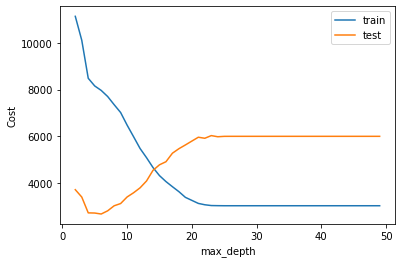

In [38]:
train_cost, test_cost = [],[]
for k in range(2,50):
    clf= DecisionTreeClassifier(criterion='entropy', splitter='best', class_weight={0:cfp,1:cfn},max_depth=k, random_state=42) 
    clf.fit(X_train,y_train)
    y_pred_test = clf.predict(X_test)
    cm_test=metrics.confusion_matrix(y_test, y_pred_test)
    loss=loss_calc(cm_test)
    test_cost.append(loss)
    
    y_pred_train = clf.predict(X_train)
    cm_train=metrics.confusion_matrix(y_train, y_pred_train)
    loss=loss_calc(cm_train)
    train_cost.append(loss)
    
plt.plot(range(2,50), train_cost)
plt.plot(range(2,50), test_cost)
plt.legend(['train','test'])
plt.xlabel('max_depth')
plt.ylabel('Cost')
plt.show()

from the graph we can see that the best max_depth value is from this range- (2,10) so in the best_estimator_dt function we will choose 
the max_depth value option to be in this range

#### Build best estimator of decision tree classifier:

In [39]:
def best_estimator_dt(iteration, X_train, y_train):
    
    dt = DecisionTreeClassifier(random_state=42,class_weight={0:cfp,1:cfn})
    
    pipe_dt = Pipeline([('over', SMOTE()),('under',RandomUnderSampler()),('dt', dt)])

    over__sampling_strategy=[0.2,0.4,0.6,0.8,1]
    under__sampling_strategy=[0.2,0.4,0.6,0.8,1]
    
    criterion = ['entropy','gini']

    max_depth = [int(x) for x in range(2,10)]
    max_depth.append(None)

    max_features = [None,'auto', 'log2', 2, 5, 8]

    max_leaf_nodes=[None,10,20,30,40,50,60,70,80,90] 

    min_samples_split = [None,25,50, 100,150,200]

    min_samples_leaf = [10,30, 50, 100]
    
    bootstrap = [True, False]

    min_weight_fraction_leaf=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]


    parameters = {'dt__criterion': criterion,
                   'dt__max_depth': max_depth,
                   'dt__max_features': max_features,
                   'dt__max_leaf_nodes': max_leaf_nodes,
                   'dt__min_samples_leaf': min_samples_leaf,
                   'dt__min_weight_fraction_leaf': min_weight_fraction_leaf,
                   'dt__min_samples_split': min_samples_split,
                   'over__sampling_strategy': over__sampling_strategy,
                   'under__sampling_strategy':under__sampling_strategy
                  
                 }
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    dt_random = RandomizedSearchCV(estimator = pipe_dt, param_distributions = parameters, n_iter = iteration, cv = cv,scoring=cost,
                               verbose = 2, random_state = 42, n_jobs = -1)

    dt_random.fit(X_train,y_train)
    param= dt_random.best_params_
    #deals with none option
    if param['dt__max_features']==None or isinstance(param['dt__max_features'], str) :
        max_features=[param['dt__max_features']]
    else:
        max_features=[param['dt__max_features']+i for i in range(-1,2)]
        
    if param['dt__max_leaf_nodes']==None:
        max_leaf_nodes=[None,95,100]
    else:
        max_leaf_nodes=[param['dt__max_leaf_nodes']+5*i for i in range(-1,2)]
        
    if param['dt__max_depth']==None:
        max_depth=[None,25,30]
    else:
        max_depth=[param['dt__max_depth']+i for i in range(-1,2)]
        
    param_grid = {'dt__criterion': [param['dt__criterion']],
                   'dt__max_depth': max_depth,
                   'dt__max_features': max_features,
                   'dt__max_leaf_nodes': max_leaf_nodes,
                   'dt__min_samples_leaf': [param['dt__min_samples_leaf']+5*i for i in range(-1,2)],
                   'dt__min_weight_fraction_leaf': [param['dt__min_weight_fraction_leaf']+ round(0.1*i,2)for i in range(-1,2)],
                   'dt__min_samples_split': [param['dt__min_samples_split']+25*i for i in range(-1,2)],
                    'over__sampling_strategy': [param['over__sampling_strategy']+ round(0.1*i,2) for i in range(-1,2)],
                    'under__sampling_strategy':[param['under__sampling_strategy'] +round(0.1*i,2) for i in range(-1,2)]
                
                 }


    grid_search = GridSearchCV(estimator = pipe_dt, param_grid = param_grid, cv = cv, n_jobs = -1, verbose = 2,scoring=cost)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


In [40]:
clf_decision_tree=best_estimator_dt(500, X_train, y_train)
clf_list.append(clf_decision_tree)
clf_decision_tree.get_params()

Fitting 15 folds for each of 500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 21.0min finished


Fitting 15 folds for each of 2187 candidates, totalling 32805 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1309 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1854 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2545 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 3376 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 4325 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 5378 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 6749 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 7972 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 9465 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 11218 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 13057 tasks      

{'memory': None,
 'steps': [('over', SMOTE(sampling_strategy=0.30000000000000004)),
  ('under', RandomUnderSampler(sampling_strategy=0.5)),
  ('dt',
   DecisionTreeClassifier(class_weight={0: 1, 1: 15}, max_depth=6,
                          max_leaf_nodes=95, min_samples_leaf=30,
                          min_samples_split=125, random_state=42))],
 'verbose': False,
 'over': SMOTE(sampling_strategy=0.30000000000000004),
 'under': RandomUnderSampler(sampling_strategy=0.5),
 'dt': DecisionTreeClassifier(class_weight={0: 1, 1: 15}, max_depth=6,
                        max_leaf_nodes=95, min_samples_leaf=30,
                        min_samples_split=125, random_state=42),
 'over__k_neighbors': 5,
 'over__n_jobs': None,
 'over__random_state': None,
 'over__sampling_strategy': 0.30000000000000004,
 'under__random_state': None,
 'under__replacement': False,
 'under__sampling_strategy': 0.5,
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': {0: 1, 1: 15},
 'dt__criterion': 'gini',
 'dt__max_depth':

In [41]:
print( "\033[4m\npredict X_test data:\033[0m")
print_clf(clf_decision_tree,X_test, y_test)
print( "\033[4m\npredict X_train data:\033[0m")
print_clf(clf_decision_tree,X_train, y_train)


predict X_test data:
confusion matrix:


,0,1
0,2126,3222
1,20,727


Cost: 3522

predict X_train data:
confusion matrix:


,0,1
0,6393,9824
1,50,2018


Cost: 10574


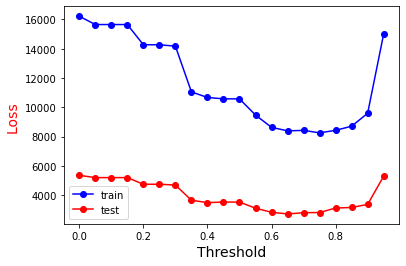


predict X_test data:
confusion matrix:


,0,1
0,3619,1729
1,72,675


Cost: 2809

predict X_train data:
confusion matrix:


,0,1
0,10801,5416
1,189,1879


Cost: 8251


In [42]:
min_threshold=min_threshold_value(clf_decision_tree,X_train, X_test, y_train, y_test)

In [43]:
loss_dict = mod_cv(clf_decision_tree, X, y,min_threshold)

In [44]:
model_dict['clf_decision_tree'] = list(loss_dict.values())[0]

In [45]:
treshols_dict['clf_decision_tree']=min_threshold

### Random Forest Classifier

* data evaluation on Random Forest Classifier

In [46]:
cm_dict_rf, loss_dict_rf=data_cv(data_option_dict,RandomForestClassifier(class_weight={0:cfp,1:cfn},random_state=42))

In [47]:
best_data_option = ttest_find_best(loss_dict_rf)
best_data_option

'data_cat_with_debts_dummies'

In [48]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

#### Let's see how a n_estimators parameter can affect the performances, of the <b> train </b> and  the <b> test </b>we got from train_test_split

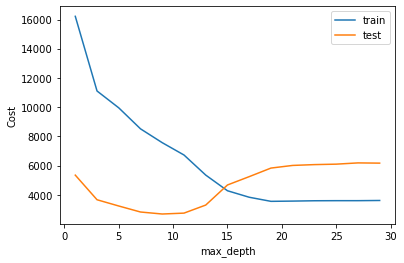

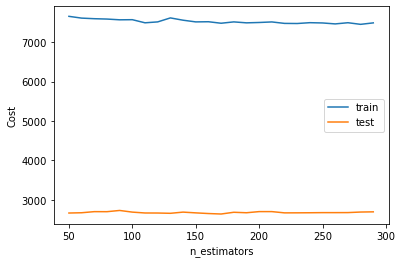

In [49]:
train_cost, test_cost = [],[]
min_cost_depth=30
for x in range(1,30,2):
    
    clf= RandomForestClassifier(class_weight={0:cfp,1:cfn},max_depth=x, random_state=42) 
    clf.fit(X_train,y_train)
    
    y_pred_test = clf.predict(X_test)
    cm_test=metrics.confusion_matrix(y_test, y_pred_test)
    loss=loss_calc(cm_test)
    test_cost.append(loss)
    if(loss<=min(test_cost)):
        min_cost_depth=x
        
    y_pred_train = clf.predict(X_train)
    cm_train=metrics.confusion_matrix(y_train, y_pred_train)
    loss=loss_calc(cm_train)
    train_cost.append(loss)


    
plt.plot(range(1,30,2), train_cost)
plt.plot(range(1,30,2), test_cost)
plt.legend(['train','test'])
plt.xlabel('max_depth')
plt.ylabel('Cost')
plt.show()


train_cost, test_cost = [],[]

for x in range(50,300,10):
    
    clf= RandomForestClassifier(class_weight={0:cfp,1:cfn},n_estimators=x,max_depth=min_cost_depth,random_state=42) 
    clf.fit(X_train,y_train)
    
    y_pred_test = clf.predict(X_test)
    cm_test=metrics.confusion_matrix(y_test, y_pred_test)
    loss=loss_calc(cm_test)
    test_cost.append(loss)
    
    y_pred_train = clf.predict(X_train)
    cm_train=metrics.confusion_matrix(y_train, y_pred_train)
    loss=loss_calc(cm_train)
    train_cost.append(loss)
    
plt.plot(range(50,300,10), train_cost)
plt.plot(range(50,300,10), test_cost)
plt.legend(['train','test'])
plt.xlabel('n_estimators')
plt.ylabel('Cost')
plt.show()


n_estimators- (50-150)
max_depth- (5-13)

In [50]:
def best_estimator_rf(iteration, X_train, y_train):
      
    clf_rf = RandomForestClassifier(class_weight={0:cfp,1:cfn}, random_state=42)
    
    pipe_rf = Pipeline([('over', SMOTE()),('under',RandomUnderSampler()),('rf', clf_rf)])

    over__sampling_strategy=[0.2,0.4,0.6,0.8,1]
    under__sampling_strategy=[0.2,0.4,0.6,0.8,1]

    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]

    max_features = ['auto', 'log2']

    max_depth = [5,7,9,11,13]
    max_depth.append(None)

    min_samples_split = [None,50, 100,150,200]

    min_samples_leaf = [10,30, 50, 100]
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'rf__n_estimators': n_estimators,
                   'rf__max_features': max_features,
                   'rf__max_depth': max_depth,
                   'rf__min_samples_split': min_samples_split,
                   'rf__min_samples_leaf': min_samples_leaf,
                   'rf__bootstrap': bootstrap,
                   'over__sampling_strategy':over__sampling_strategy,
                   'under__sampling_strategy':under__sampling_strategy
                  
                  }
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    rf_random = RandomizedSearchCV(estimator = pipe_rf, param_distributions = random_grid, n_iter = iteration, cv = cv,
                                   verbose = 2, random_state = 42, n_jobs = -1,scoring=cost)

    rf_random.fit(X_train, y_train)
    param= rf_random.best_params_

    if param['rf__max_depth']==None:
        max_depth=[None]
    else:
         max_depth=[param['rf__max_depth']+i for i in range(-1,2)]
            
    if param['rf__min_samples_leaf']==1:
        min_samples_leaf=[1,2,3]
    else:
         min_samples_leaf=[param['rf__min_samples_leaf']+5*i for i in range(-1,2)]

    param_grid = {'rf__n_estimators': [param['rf__n_estimators']+5*i for i in range(-1,2)],
                   'rf__max_depth': max_depth,
                   'rf__max_features': [param['rf__max_features']],
                   'rf__min_samples_leaf':min_samples_leaf,
                   'rf__bootstrap':[param['rf__bootstrap']],
                   'rf__min_samples_split': [param['rf__min_samples_split']+25*i for i in range(-1,2)],
                    'under__sampling_strategy':[param['under__sampling_strategy']+ round(0.1*i,2) for i in range(-1,2)],
                    'over__sampling_strategy':[param['over__sampling_strategy']+ round(0.1*i,2) for i in range(-1,2)]

                 }

    grid_search = GridSearchCV(estimator = pipe_rf, param_grid = param_grid, cv = cv, n_jobs = -1, verbose = 2,scoring=cost)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

In [51]:
clf_random_forest=best_estimator_rf(500, X_train, y_train)
clf_list.append(clf_random_forest)
clf_random_forest.get_params()

Fitting 15 folds for each of 500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 31.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 53.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 62.3min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 67.9min finished


Fitting 15 folds for each of 729 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 3809 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4416 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5105 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 5874 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 6725 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 7656 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done 8669 tasks      | elapsed: 34.6min
[Parallel(n_jobs=-1)]: Done 9762 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 10935 out of 1093

{'memory': None,
 'steps': [('over', SMOTE(sampling_strategy=0.2)),
  ('under', RandomUnderSampler(sampling_strategy=0.2)),
  ('rf',
   RandomForestClassifier(class_weight={0: 1, 1: 15}, max_depth=14,
                          min_samples_leaf=5, min_samples_split=75,
                          n_estimators=67, random_state=42))],
 'verbose': False,
 'over': SMOTE(sampling_strategy=0.2),
 'under': RandomUnderSampler(sampling_strategy=0.2),
 'rf': RandomForestClassifier(class_weight={0: 1, 1: 15}, max_depth=14,
                        min_samples_leaf=5, min_samples_split=75,
                        n_estimators=67, random_state=42),
 'over__k_neighbors': 5,
 'over__n_jobs': None,
 'over__random_state': None,
 'over__sampling_strategy': 0.2,
 'under__random_state': None,
 'under__replacement': False,
 'under__sampling_strategy': 0.2,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': {0: 1, 1: 15},
 'rf__criterion': 'gini',
 'rf__max_depth': 14,
 'rf__max_features': 'aut

In [52]:
print( "\033[4m\npredict X_test data:\033[0m")
print_clf(clf_random_forest,X_test, y_test)
print( "\033[4m\npredict X_train data:\033[0m")
print_clf(clf_random_forest,X_train, y_train)


predict X_test data:
confusion matrix:


,0,1
0,3485,1863
1,49,698


Cost: 2598

predict X_train data:
confusion matrix:


,0,1
0,10291,5926
1,104,1964


Cost: 7486


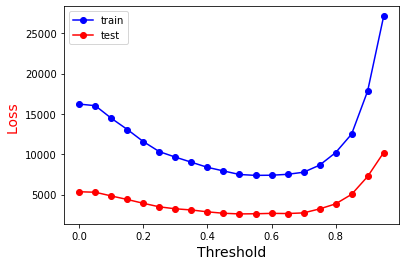


predict X_test data:
confusion matrix:


,0,1
0,3707,1641
1,65,682


Cost: 2616

predict X_train data:
confusion matrix:


,0,1
0,11090,5127
1,150,1918


Cost: 7377


In [53]:
min_threshold=min_threshold_value(clf_random_forest,X_train, X_test, y_train, y_test)

In [54]:
loss_dict = mod_cv(clf_random_forest, X, y,min_threshold)

In [55]:
model_dict['clf_random_forest'] = list(loss_dict.values())[0]

In [56]:
treshols_dict['clf_random_forest']=min_threshold

## CatBoost Classification 


* data evaluation on __CatBoost Classifier__

In [57]:
cm_dict_cb, loss_dict_cb=data_cv(data_option_dict,CatBoostClassifier(logging_level='Silent'))

In [58]:
best_data_option = ttest_find_best(loss_dict_cb)
best_data_option

'data_norm_and_not_with_debts'

In [59]:
X =  data_option_dict[best_data_option].drop(['subscribed'], axis=1)
y =  data_option_dict[best_data_option]['subscribed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

 see how a iterations parameter affect the performances, in the <b> train </b> and in the <b> test </b>:

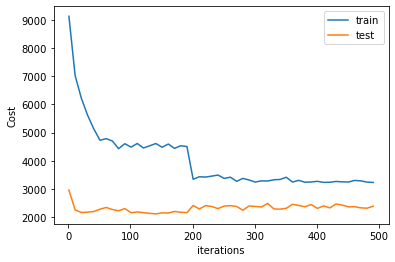

In [60]:
train_scores, test_scores = [],[]
for k in range(1,500,10):
    clf_cat_boost = CatBoostClassifier(iterations=k,verbose = False,class_weights=[cfp,cfn])
    clf_cat_boost.fit(X_train,y_train)
    
    y_pred_test = clf_cat_boost.predict(X_test)
    cm_test=metrics.confusion_matrix(y_test, y_pred_test)
    loss=loss_calc(cm_test)
    test_scores.append(loss)
    
    y_pred_train = clf_cat_boost.predict(X_train)
    cm_train=metrics.confusion_matrix(y_train, y_pred_train)
    loss=loss_calc(cm_train)
    train_scores.append(loss)
plt.plot(range(1,500,10),train_scores)
plt.plot(range(1,500,10),test_scores)
plt.legend(['train','test'])
plt.xlabel('iterations')
plt.ylabel('Cost')
plt.show()

from the graph we can see that the best iterations value is from this range- (20-150) so in the best_estimator_dt function we will choose the iterations value option to be in this range.

#### Build best estimator of random forest classifier:

In [61]:
def best_estimator_cb(iteration,X_train,y_train):
    cb=CatBoostClassifier(class_weights=[cfp,cfn],logging_level='Silent')
    
    pipe_cb = Pipeline([('over', SMOTE()),('under',RandomUnderSampler()),('cb', cb)])

    over__sampling_strategy=[0.2,0.4,0.6,0.8,1]
    under__sampling_strategy=[0.2,0.4,0.6,0.8,1]


    iterations=np.arange(20, 155,5).tolist()
    depth = [2,4,6,8,10,12,14]

    learning_rate=np.arange(0.05, 0.55,0.03).tolist()
    
    l2_leaf_reg= [1, 3, 5, 7, 9]
        
        
    grow_policy=['SymmetricTree','Depthwise','Lossguide']
    
    boosting_type =["Ordered", "Plain"]
    loss_function=['Logloss','MultiClass']

    parameters = {'cb__iterations':iterations,
                    'cb__boosting_type':boosting_type,
                    'cb__l2_leaf_reg': l2_leaf_reg,
                    'cb__depth': depth,
                    'cb__learning_rate': learning_rate,
                    'cb__loss_function':loss_function,
                    'cb__grow_policy': grow_policy,
                    'over__sampling_strategy':over__sampling_strategy,
                   'under__sampling_strategy':under__sampling_strategy
                 }
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    cb_random = RandomizedSearchCV(estimator = pipe_cb, param_distributions = parameters, n_iter = iteration, cv = cv,
                               verbose = 2, random_state = 42, n_jobs = -1,scoring=cost)

    cb_random.fit(X_train,y_train)
    param= cb_random.best_params_


    param_grid = { 'cb__boosting_type':[param['cb__boosting_type']],
                   'cb__depth': [param['cb__depth']+i for i in range(-1,2)],
                   'cb__learning_rate': [param['cb__learning_rate']+ round(0.015*i,3) for i in range(-1,2)],
                   'cb__l2_leaf_reg':[param['cb__l2_leaf_reg']+i for i in range(-1,2)],
                   'cb__loss_function':[param['cb__loss_function']],
                   'cb__grow_policy': [param['cb__grow_policy']],
                   'under__sampling_strategy':[param['under__sampling_strategy']+ round(0.1*i,2) for i in range(-1,2)],
                   'over__sampling_strategy':[param['over__sampling_strategy']+ round(0.1*i,2) for i in range(-1,2)]
                 
                 }
    grid_search = GridSearchCV(estimator = pipe_cb, param_grid = param_grid, cv = cv, n_jobs = -1, verbose = 2,scoring=cost)
    grid_search.fit(X_train,y_train)
   
    return cb_random.best_estimator_

In [201]:
clf_cat_boost=best_estimator_cb(500,X_train,y_train)
clf_cat_boost.get_params()
clf_list.append(clf_cat_boost)

Fitting 15 folds for each of 500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 28.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 92.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 114.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 162.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 260.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 287.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed: 312.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 344.7min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 440.3min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 460.2min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 647.0min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed: 734.9min finished


Fitting 15 folds for each of 729 candidates, totalling 10935 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 286 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1205 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1718 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2273 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2976 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 3793 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 4618 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 5513 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 6552 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 7609 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 8778 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 10053 tasks      |

In [202]:
print( "\033[4m\npredict X_test data:\033[0m")
print_clf(clf_cat_boost,X_test, y_test)
print( "\033[4m\npredict X_train data:\033[0m")
print_clf(clf_cat_boost,X_train, y_train)


predict X_test data:
confusion matrix:


,0,1
0,3914,1434
1,55,692


accuracy:  0.755701394585726
Cost: 2259

predict X_train data:
confusion matrix:


,0,1
0,11754,4463
1,86,1982


accuracy:  0.7512168444079846
Cost: 5753


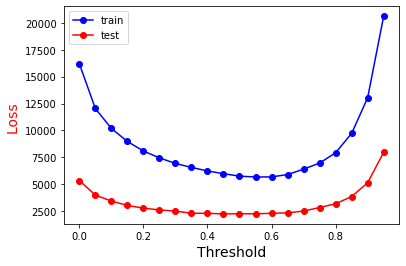


predict X_test data:
confusion matrix:


,0,1
0,4068,1280
1,65,682


accuracy:  0.7793273174733388
Cost: 2255

predict X_train data:
confusion matrix:


,0,1
0,12192,4025
1,110,1958


accuracy:  0.7738583538419469
Cost: 5675


In [203]:
min_threshold=min_threshold_value(clf_cat_boost,X_train, X_test, y_train, y_test)

In [229]:
loss_dict = mod_cv(clf_cat_boost, X, y,min_threshold)

In [230]:
model_dict['clf_cat_boost'] = list(loss_dict.values())[0]

In [247]:
treshols_dict['clf_cat_boost']=min_threshold

# Model evaluation 

#### Comparison between the list of different types of data on spesific classifier:

In [234]:
best_model=ttest_find_best(model_dict)

In [235]:
best_model

'clf_cat_boost'

#### cat boost was the third clasiffier :

In [238]:
best_clf=clf_list[2]

In [239]:
best_clf

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x000002AD688484C0>)])

In [249]:
min_thresh_best=treshols_dict['clf_cat_boost']

### check overfitting according the validation data:

In [268]:
X_train =  data_norm_and_not_with_debts.drop(['subscribed'], axis=1)
y_train =  data_norm_and_not_with_debts['subscribed']

In [269]:
X_valid=valid_norm_and_not_with_debts.drop(['subscribed'], axis=1)
y_valid=valid_norm_and_not_with_debts['subscribed']

In [271]:
best_clf

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x000002AD688484C0>)])

In [272]:
best_clf.fit(X_train,y_train)

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x000002AD688484C0>)])

In [273]:
y_prob_train= best_clf.predict_proba(X_train)
y_pred_min_train = [0 if p[1]<min_thresh_best else 1 for p in y_prob_train]
print_clf(best_clf, X_train, y_train,y_pred_min_train)

confusion matrix:


,0,1
0,16085,5480
1,156,2659


accuracy:  0.7688269073010664
Cost: 7820


In [274]:
y_prob_valid= best_clf.predict_proba(X_valid)
y_pred_min_valid = [0 if p[1]<min_thresh_best else 1 for p in y_prob_valid]
print_clf(best_clf, X_valid, y_valid,y_pred_min_valid)

confusion matrix:


,0,1
0,3758,1642
1,52,652


accuracy:  0.7224770642201835
Cost: 2422


# Test Prediction:
create CSV file with a predictions for the attached test data set:</br>
the test file "marketing_campaigns_test_pre_processing_part1.csv" is the test data after pre-processing (we did the tet pre-process in notebook part1).</br>
As we saw the 'catboost' was the best classifier with data option 'data_norm_and_not_with_debts'. 
* first we transform the test data features to be the same as  data_norm_and_not_with_debts features
*we apply clf_cat_boost on the test data
* we save the predict lable in csv

In [278]:
test = pd.read_csv("./marketing_campaigns_test_pre_processing_part1.csv")

In [279]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14694 entries, 0 to 14693
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      14694 non-null  int64  
 1   status                  14694 non-null  int64  
 2   education               14694 non-null  int64  
 3   profession              14694 non-null  int64  
 4   device                  14694 non-null  int64  
 5   loan                    14694 non-null  int64  
 6   mortgage                14694 non-null  int64  
 7   credit                  14694 non-null  int64  
 8   positive                14694 non-null  int64  
 9   l_season                14694 non-null  int64  
 10  p_participant           14694 non-null  int64  
 11  debts                   14694 non-null  int64  
 12  age_z_norm              14694 non-null  float64
 13  account_balance_z_norm  14694 non-null  float64
 14  n_contact_z_norm        14694 non-null

In [285]:
test_norm_and_not_with_debts = test[['status', 'profession', 'device', 'debts', 'p_participant', 'l_season', 
                              'l_call_duration_z_norm', 'account_balance_z_norm','n_contact_z_norm',  'age_z_norm', 'l_day_z_norm']].copy()
test_norm_and_not_with_debts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14694 entries, 0 to 14693
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   status                  14694 non-null  int64  
 1   profession              14694 non-null  int64  
 2   device                  14694 non-null  int64  
 3   debts                   14694 non-null  int64  
 4   p_participant           14694 non-null  int64  
 5   l_season                14694 non-null  int64  
 6   l_call_duration_z_norm  14694 non-null  float64
 7   account_balance_z_norm  14694 non-null  float64
 8   n_contact_z_norm        14694 non-null  float64
 9   age_z_norm              14694 non-null  float64
 10  l_day_z_norm            14694 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 1.2 MB


### we will combine the validation and the train  after we checked that we don't have overfitting in order to be more accurate when we make our prediction on the test/

In [290]:
frames = [data_norm_and_not_with_debts, valid_norm_and_not_with_debts]
train = pd.concat(frames)
X_train =  train.drop(['subscribed'], axis=1)
y_train =  train['subscribed']

In [292]:
best_clf.fit(X_train,y_train)

Pipeline(steps=[('over', SMOTE(sampling_strategy=0.2)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('cb',
                 <catboost.core.CatBoostClassifier object at 0x000002AD688484C0>)])

In [293]:
y_predict_test=best_clf.predict(test_norm_and_not_with_debts)

In [294]:
y_predict_test

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [297]:
test['subscribed-predict']=np.reshape(y_predict_test, len(y_predict_test))

In [299]:
test['subscribed-predict'].value_counts()

0    7927
1    6767
Name: subscribed-predict, dtype: int64

In [300]:
test.to_csv('test_prediction.csv')